In [1]:
!git clone https://github.com/jan1na/Neural-Cellular-Automata.git

%cd Neural-Cellular-Automata

Cloning into 'Neural-Cellular-Automata'...
remote: Enumerating objects: 102, done.
remote: Counting objects: 100% (102/102), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 102 (delta 61), reused 43 (delta 23), pack-reused 0 (from 0)
Receiving objects: 100% (102/102), 333.17 KiB | 9.80 MiB/s, done.
Resolving deltas: 100% (61/61), done.
/content/Neural-Cellular-Automata


In [2]:
!pip install medmnist torch torchvision tqdm

import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
from medmnist import PathMNIST, INFO
from train_utils import train, evaluate, plot_training_history
from models import NCA2
import matplotlib.pyplot as plt
import random
import os

# Mount Google Drive
from google.colab import drive

drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.0 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256

In [3]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = PathMNIST(split='train', transform=transform, download=True)
val_dataset = PathMNIST(split='val', transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

100%|██████████| 206M/206M [01:04<00:00, 3.20MB/s]


# Dataset Overview

In [11]:
print(f"train_dataset length: {len(train_dataset)}")
print(f"val_dataset length: {len(val_dataset)}")
print(f"Numb classes: {INFO['pathmnist']['label']}")
print(f"Data shape: {train_dataset[0][0].shape}")

train_dataset length: 89996
val_dataset length: 10004
Numb classes: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
Data shape: torch.Size([3, 28, 28])


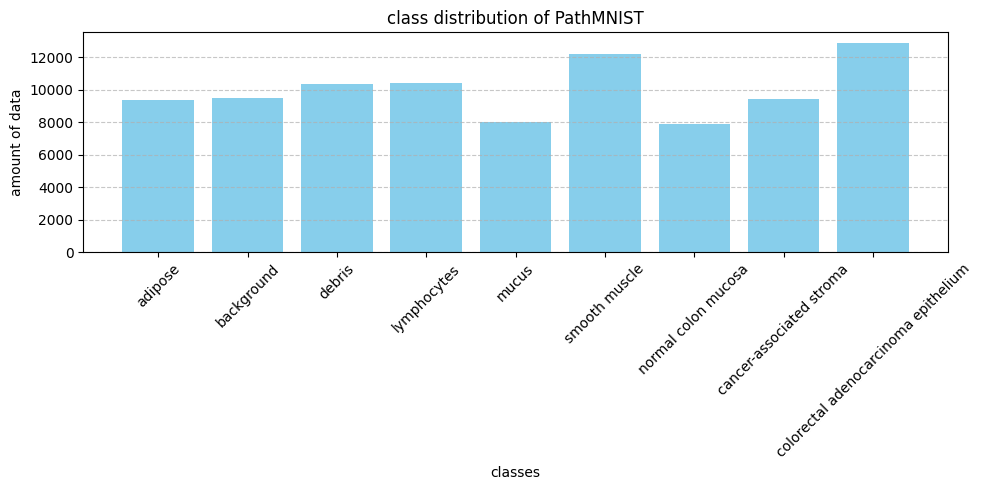

In [38]:
# plotting class distribution

data_dist_path = '/content/drive/MyDrive/NCA/plots/data_distribution.png'
os.makedirs(os.path.dirname(model_path), exist_ok=True)

class_counts = [0] * n_classes

for data, target in train_loader:
    for label in target:
        class_counts[label.item()] += 1

class_labels = list(INFO['pathmnist']['label'].values())
plt.figure(figsize=(10, 5))
plt.bar(class_labels, class_counts, color='skyblue')
plt.title('class distribution of PathMNIST')
plt.xlabel('classes')
plt.ylabel('amount of data')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(data_dist_path, dpi=300)
plt.show()

/tmp/ipython-input-33-3273146053.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if int(label) == i:


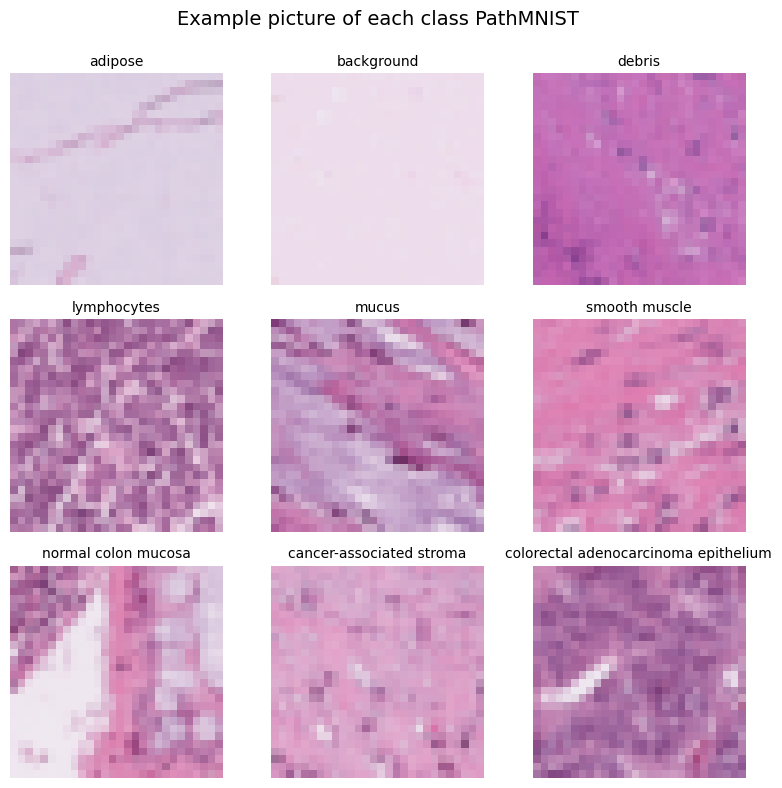

In [33]:
# plotting a picture of each class

test_data_path = '/content/drive/MyDrive/NCA/plots/test_data.png'
os.makedirs(os.path.dirname(model_path), exist_ok=True)

fig, axes = plt.subplots(3, 3, figsize=(8, 8))
fig.suptitle("Example picture of each class PathMNIST", fontsize=14)

for i, ax in enumerate(axes.flat):

    # searching for random picture and plotting it
    for image, label in train_dataset:
        if int(label) == i:
            img = image.permute(1, 2, 0)
            ax.imshow(img)
            ax.set_title(class_labels[i], fontsize=10)
            ax.axis('off')
            break


plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.savefig(test_data_path, dpi=300)
plt.show()

# Train and plot data

Epoch 01: Train Acc: 0.5802, Val Acc: 0.6555
New best model saved to /content/drive/MyDrive/NCA/best_nca_pathmnist.pth


Epoch 02: Train Acc: 0.7335, Val Acc: 0.7620
New best model saved to /content/drive/MyDrive/NCA/best_nca_pathmnist.pth


Epoch 03: Train Acc: 0.8257, Val Acc: 0.8408
New best model saved to /content/drive/MyDrive/NCA/best_nca_pathmnist.pth


Epoch 04: Train Acc: 0.8667, Val Acc: 0.8903
New best model saved to /content/drive/MyDrive/NCA/best_nca_pathmnist.pth


Epoch 05: Train Acc: 0.8898, Val Acc: 0.9044
New best model saved to /content/drive/MyDrive/NCA/best_nca_pathmnist.pth


Epoch 06: Train Acc: 0.9041, Val Acc: 0.8954


Epoch 07: Train Acc: 0.9124, Val Acc: 0.9338
New best model saved to /content/drive/MyDrive/NCA/best_nca_pathmnist.pth


Epoch 08: Train Acc: 0.9216, Val Acc: 0.9378
New best model saved to /content/drive/MyDrive/NCA/best_nca_pathmnist.pth


Epoch 09: Train Acc: 0.9276, Val Acc: 0.9472
New best model saved to /content/drive/MyDrive/NCA/best_nca_pathmnist.pth


Epoch 10: Train Acc: 0.9314, Val Acc: 0.9240


Epoch 11: Train Acc: 0.9350, Val Acc: 0.9412


Epoch 12: Train Acc: 0.9390, Val Acc: 0.9388


Epoch 13: Train Acc: 0.9412, Val Acc: 0.9222


Epoch 14: Train Acc: 0.9441, Val Acc: 0.9576
New best model saved to /content/drive/MyDrive/NCA/best_nca_pathmnist.pth


Epoch 15: Train Acc: 0.9472, Val Acc: 0.9578
New best model saved to /content/drive/MyDrive/NCA/best_nca_pathmnist.pth


Epoch 16: Train Acc: 0.9478, Val Acc: 0.9488


Epoch 17: Train Acc: 0.9500, Val Acc: 0.9531


Epoch 18: Train Acc: 0.9524, Val Acc: 0.9426


Epoch 19: Train Acc: 0.9531, Val Acc: 0.9421


Epoch 20: Train Acc: 0.9539, Val Acc: 0.9571


Epoch 21: Train Acc: 0.9545, Val Acc: 0.9526


Epoch 22: Train Acc: 0.9569, Val Acc: 0.9563


Epoch 23: Train Acc: 0.9584, Val Acc: 0.9264


Epoch 24: Train Acc: 0.9595, Val Acc: 0.9337


Epoch 25: Train Acc: 0.9605, Val Acc: 0.9532


Epoch 26: Train Acc: 0.9605, Val Acc: 0.9580
New best model saved to /content/drive/MyDrive/NCA/best_nca_pathmnist.pth


Epoch 27: Train Acc: 0.9624, Val Acc: 0.9475


Epoch 28: Train Acc: 0.9625, Val Acc: 0.9557


Epoch 29: Train Acc: 0.9633, Val Acc: 0.9551


Epoch 30: Train Acc: 0.9629, Val Acc: 0.9462
Training completed.


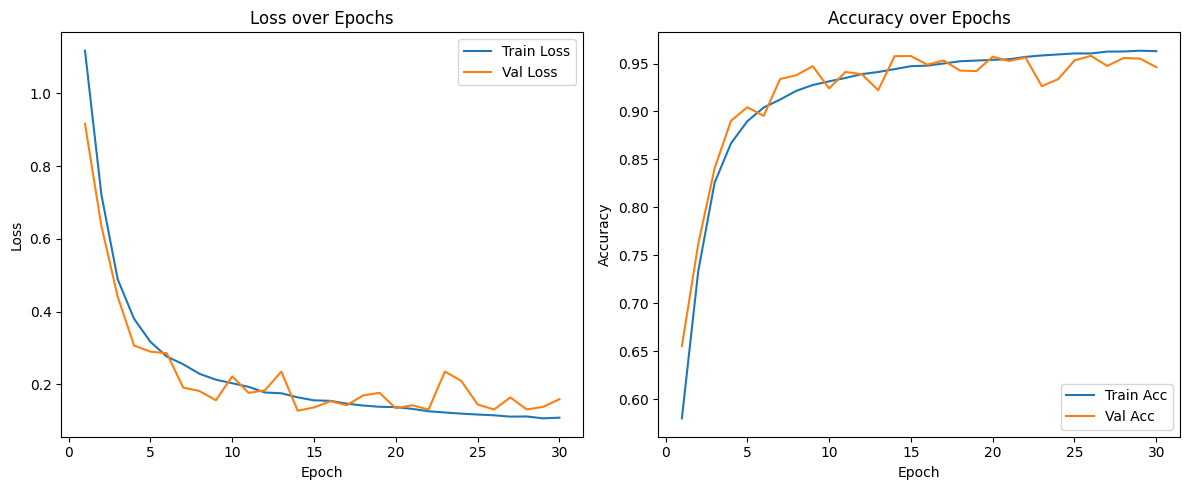

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NCA2().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
NUM_EPOCHS = 30

model_path = '/content/drive/MyDrive/NCA/best_nca_pathmnist.pth'
os.makedirs(os.path.dirname(model_path), exist_ok=True)

plot_save_path = '/content/drive/MyDrive/NCA/plots/nca_training_history.png'
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

best_acc = 0

for epoch in range(1, NUM_EPOCHS + 1):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device, is_NCA=True)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device, is_NCA=True)

    # Save for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch:02d}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), model_path)
        print(f"New best model saved to {model_path}")

    if val_acc > 0.96:
        print("Converged (validation accuracy > 96%)")
        break

print("Training completed.")
plot_training_history(train_losses, train_accuracies, val_losses, val_accuracies, plot_save_path)